## Optimizing Existing Networks

Nengo DL is not confined to opimizing cutom made networks, it can also be used to make existing networks better, or acheive the same result with less neurons. What this example will show is how to train a circular convolution network.

Circular convolution is a key opeartion used to process [semantic pointers](http://compneuro.uwaterloo.ca/research/spa/semantic-pointer-architecture.html) and by optimizing this smaller network, larger more complex networks that utilize circular convolution can benefit.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import nengo
import nengo_dl
%load_ext nengo.ipynb
from nengo.spa import Vocabulary

import random
import string
import sys
from io import StringIO
import tensorflow as tf

/home/clvcooke/nengo_deep/lib/python3.4/site-packages/nengo_dl/__init__.py:18: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  warnings.warn("No GPU support detected. It is recommended that you "


<IPython.core.display.Javascript object>

To properly train the network, we generate novel training data by randomly generating semantic pointers. Otherwise, by simply training on the same pointers each time the network will quickly overfit the training data.

In [2]:
def gen_pointers(amount, vocabulary):
    pairs = []
    for v in range(amount):
        # generate amount pairs
        # keys start with A, second element starts with B, third starts with C
        conv_key = 'C' + str(v)
        point_key_1= 'A' + str(v)
        pointer_1 = vocabulary.create_pointer(attempts=500)
        point_key_2 = 'B' + str(v)
        pointer_2 = vocabulary.create_pointer(attempts=500)
        vocabulary.add(point_key_1, pointer_1)
        vocabulary.add(point_key_2, pointer_2)
        vocabulary.add(conv_key, vocabulary.parse(point_key_2 + "*" + point_key_1))
        
def repeat_pointer(pointer, steps):
    return np.repeat(np.expand_dims(pointer, axis=0), steps, axis=0)

def generate_data(dims, seed, amount, steps):
    state = np.random.RandomState(seed)
    vocabulary = Vocabulary(dimensions=dims, rng=state)
    gen_pointers(amount, vocabulary)
    A = np.asarray([repeat_pointer(vocabulary['A' + str(i)].v,steps) for i in range(amount)])
    B = np.asarray([repeat_pointer(vocabulary['B' + str(i)].v,n_steps) for i in range(amount)])
    C = np.asarray([repeat_pointer(vocabulary['C' + str(i)].v,n_steps) for i in range(amount)])
    return A, B, C, vocabulary

# Number of dimensions for the Semantic Pointers
dimensions = 50
n_steps = 300
minibatch_size = 10

test_a, test_b, test_c, vocab = generate_data(dimensions, 0, minibatch_size, n_steps)

To model the network in a way which will yield useful final results spiking neurons are used. This way, once we optimize the convolution portion of the network it is still able to be used in other models.

The network is not very complex, the circular convolution portion is already defined by Nengo, all that is required is connecting input nodes to the circular convolution network which will feed in the pointers to be convoluted.

In this example only 5 neurons are used per dimension for the circular convolution.

In [5]:
model = nengo.Network()
with model:
    model.config[nengo.Ensemble].neuron_type = nengo_dl.SoftLIFRate(sigma=0.1, tau_rc=0.022, tau_ref=0.002)
    model.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    model.config[nengo.Ensemble].bias = nengo.dists.Uniform(-1, 1)

    # Get the raw vectors for the pointers using `vocab['A'].v`
    a = nengo.Node(output=vocab['A0'].v)
    b = nengo.Node(output=vocab['B0'].v)

    # Make the circular convolution network with 5 neurons per dimension
    cconv = nengo.networks.CircularConvolution(5, dimensions=dimensions)

    # Connect the input nodes to the input slots `A` and `B` on the network
    nengo.Connection(a, cconv.input_a)
    nengo.Connection(b, cconv.input_b)

    # Probe the output
    out = nengo.Probe(cconv.output, synapse=0.03)

We now run the network in its default state to get an idea of the baseline performance. The performance shown is very poor, there is not much of a distinction between the output of the network and the rest of the pointers in the vocabulary. Ideally the output would be clearly `C0`, the result of the convolution between `A0` and `B0` which are the inputs.

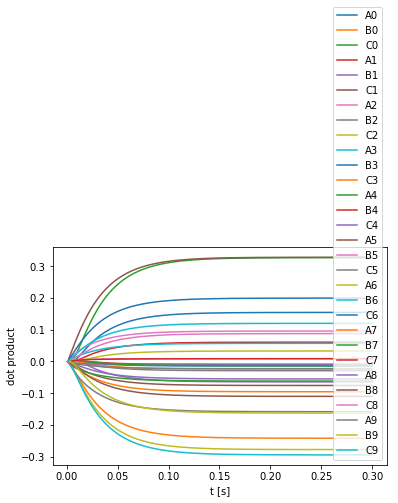

In [7]:
with nengo.Simulator(model) as sim:
    sim.run(0.3)
plt.figure()
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[out], vocab))
plt.legend(vocab.keys, loc=4)
plt.xlabel("t [s]")
plt.ylabel("dot product");

To train the network the standard procedure can be followed, however in this case the standard objective function will not used. Instead the cosine distance between the target pointer (the true result of the convolution) and the network output will be calculated. Throughout training the objective will be to reduce that distance.

In [ ]:
def objective_cosine(outputs, targets):
    return tf.abs(tf.losses.cosine_distance(targets, outputs, dim=2))
    
with nengo_dl.Simulator(model, step_blocks=n_steps, minibatch_size=minibatch_size, device="/cpu:0") as sim:
    test_input_feed = {a:test_a,
                       b:test_b}
    test_output_feed = {out: test_c}    
    optimizer = tf.train.RMSPropOptimizer(5e-3, decay=0.9, momentum=0.0, epsilon=1e-10, use_locking=False, centered=False, name='RMSProp')
    losses = []
    print("LOSS: " + str(sim.loss(test_input_feed, test_output_feed, objective_cosine)))
    for e in range(120):
        print("ROUND: " + str(e))
        train_a, train_b, train_c, _ = generate_data(dimensions, e+1, minibatch_size, n_steps)
        input_feed = {a:train_a, 
                      b: train_b}
        output_feed = {out: train_c}
        sim.train(input_feed, output_feed, optimizer, n_epochs=1, objective=objective_cosine)
        loss = sim.loss(test_input_feed, test_output_feed, objective_cosine)
        losses.append(loss)
        print("LOSS: " + str(loss))
    sim.save_params('circular_convolution-softlif')
    sim.run(0.3)

To visualize the progress of the network we plot the loss vs. the training round. Near the end of the trainining we show that the network has hit its minimum, as instead of continuing to decrease as the trend would suggest it "bottoms out" and starts fluctuating around the minimum value. 

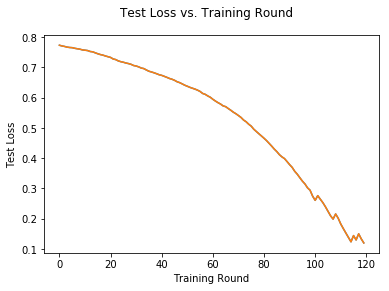

In [10]:
plt.figure()
plt.plot(losses)
plt.xlabel('Training Round')
plt.ylabel('Test Loss')
plt.suptitle('Test Loss vs. Training Round')
plt.plot(losses)

After training we run the same test on the network and plot the output. The improvement is very clear, prior to training the network's values were all very low, and some too close together to give a useful output. Now it is clearly shown the output vector is closest to `C0`, which is the numerical result of the circular convolution of `A0` and `B0` which were the two inputs

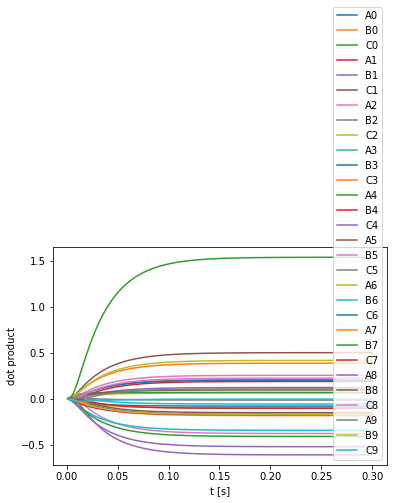

In [12]:
output = sim.data[out]
plt.figure()
plt.plot(sim.trange(), nengo.spa.similarity(output[0], vocab))
plt.legend(vocab.keys, loc=4)
plt.xlabel("t [s]")
plt.ylabel("dot product");

In a future example we will show how to integrate these training improvments into a larger network and improve the performance of the network as a whole